In [126]:
randomSeed = 250308
FOLDER = "./output/exp_icd10_gs_2022-09-07--20-29-44-lgbm-rf-epoch25-fixed-split/"

from heapq import merge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import dataclasses
from imblearn.under_sampling import RandomUnderSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from neo4pipeline.bases import ml_base
from neo4pipeline.utils import file_utils
import logging
from typing import List
import pandas as pd
import numpy as np

import plotnine as pl
import patchworklib as pw

from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb

# import rpy2
# %load_ext rpy2.ipython
# import rpy2.ipython.html
# rpy2.ipython.html.init_printing()

# from rpy2.robjects.lib.dplyr import DataFrame
# from rpy2.robjects import rl

# from rpy2.robjects import pandas2ri
# pandas2ri.activate()

# Setup

In [2]:
from neo4j import GraphDatabase

class __Neo4jConnection:
    
    # db = ""
    
    def __init__(self, uri, user, pwd, db):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        self.db = db
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, return_response = True):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=self.db) if self.db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        if return_response:
            return response

def create_neo4j_connection(neo_usr, neo_pwd, neo_host, neo_bolt, neo_db ):

    n4j_bolt_url = f"bolt://{neo_host}:{neo_bolt}"

    n4j_conn = __Neo4jConnection(uri=n4j_bolt_url, 
                            user=neo_usr,              
                            pwd=neo_pwd, 
                            db = neo_db)

    return n4j_conn

n4j = create_neo4j_connection(neo_usr = "neo4j", neo_pwd = "passw0rd", 
    neo_host = "neo_experiment", 
    neo_db = "neo4j", 
    neo_bolt  = 7687)

n4j.query("CALL gds.graph.list() YIELD graphName")

[]

# Compare no hierarchy with hierarchy

## Do projections

In [451]:
# 1. delete all projections

graphs = n4j.query("CALL gds.graph.list() YIELD graphName")

for g in graphs:
    name = g["graphName"]
    logging.info(f"...drop {name}")
    _ = n4j.query(f"CALL gds.graph.drop('{name}') YIELD graphName")
    print("dropped " + name)

dropped no_hier_undirected
dropped hier_natural
dropped no_hier_natural
dropped hier_undirected


In [452]:
projections = {
    "no_hier" : "no_hier_natural",
    "hier" : "hier_natural",
    "no_hier_undirected" : "no_hier_undirected",
    "hier_undirected" : "hier_undirected",
    # "no_hier_reverse" : "no_hier_reverse",
    # "hier_reverse" : "hier_reverse",
}


# 2. make one projection without hierarchy - directed
res = n4j.query(
'''
    CALL gds.graph.project(
        '{name}',
        {{
            Admission: {{properties: ['dummy_prop']}},
            Dx: {{properties: ['dummy_prop']}}
        }},
        {{
            HAS_DX:{{orientation: '{direction}'}},
            SUBSUMES:{{orientation: '{direction}'}}
        }}
    )
    YIELD graphName, nodeCount, relationshipCount
'''.format(**{"name": projections["no_hier"], "direction": "NATURAL"})
)
print(res)

# 3. make one projection with hierarchy - directed
res = n4j.query(
'''
    CALL gds.graph.project(
        '{name}',
        {{
            Admission: {{properties: ['dummy_prop']}},
            Dx: {{properties: ['dummy_prop']}}
        }},
        {{
            HAS_DX:{{orientation: '{direction}'}}
        }}
    )
    YIELD graphName, nodeCount, relationshipCount
'''.format(**{"name": projections["hier"], "direction": "NATURAL"})
)
print(res)

# 4. make one projection without hierarchy - UNdirected
res = n4j.query(
'''
    CALL gds.graph.project(
        '{name}',
        {{
            Admission: {{properties: ['dummy_prop']}},
            Dx: {{properties: ['dummy_prop']}}
        }},
        {{
            HAS_DX:{{orientation: '{direction}'}},
            SUBSUMES:{{orientation: '{direction}'}}
        }}
    )
    YIELD graphName, nodeCount, relationshipCount
'''.format(**{"name": projections["no_hier_undirected"], "direction": "UNDIRECTED"})
)
print(res)

# 5. make one projection with hierarchy - UNdirected
res = n4j.query(
'''
    CALL gds.graph.project(
        '{name}',
        {{
            Admission: {{properties: ['dummy_prop']}},
            Dx: {{properties: ['dummy_prop']}}
        }},
        {{
            HAS_DX:{{orientation: '{direction}'}}
        }}
    )
    YIELD graphName, nodeCount, relationshipCount
'''.format(**{"name": projections["hier_undirected"], "direction": "UNDIRECTED"})
)
print(res)

########

# # 2. make one projection without hierarchy - directed
# res = n4j.query(
# '''
#     CALL gds.graph.project(
#         '{name}',
#         {{
#             Admission: {{}},
#             Dx: {{}}
#         }},
#         {{
#             HAS_DX:{{orientation: '{direction}'}},
#             SUBSUMES:{{orientation: '{direction}'}}
#         }}
#     )
#     YIELD graphName, nodeCount, relationshipCount
# '''.format(**{"name": projections["no_hier"], "direction": "NATURAL"})
# )
# print(res)

# # 3. make one projection with hierarchy - directed
# res = n4j.query(
# '''
#     CALL gds.graph.project(
#         '{name}',
#         {{
#             Admission: {{}},
#             Dx: {{}}
#         }},
#         {{
#             HAS_DX:{{orientation: '{direction}'}}
#         }}
#     )
#     YIELD graphName, nodeCount, relationshipCount
# '''.format(**{"name": projections["hier"], "direction": "NATURAL"})
# )
# print(res)

# # 4. make one projection without hierarchy - UNdirected
# res = n4j.query(
# '''
#     CALL gds.graph.project(
#         '{name}',
#         {{
#             Admission: {{}},
#             Dx: {{}}
#         }},
#         {{
#             HAS_DX:{{orientation: '{direction}'}},
#             SUBSUMES:{{orientation: '{direction}'}}
#         }}
#     )
#     YIELD graphName, nodeCount, relationshipCount
# '''.format(**{"name": projections["no_hier_undirected"], "direction": "UNDIRECTED"})
# )
# print(res)

# # 5. make one projection with hierarchy - UNdirected
# res = n4j.query(
# '''
#     CALL gds.graph.project(
#         '{name}',
#         {{
#             Admission: {{}},
#             Dx: {{}}
#         }},
#         {{
#             HAS_DX:{{orientation: '{direction}'}}
#         }}
#     )
#     YIELD graphName, nodeCount, relationshipCount
# '''.format(**{"name": projections["hier_undirected"], "direction": "UNDIRECTED"})
# )
# print(res)

# # 6. make one projection without hierarchy - REVERSE
# res = n4j.query(
# '''
#     CALL gds.graph.project(
#         '{name}',
#         {{
#             Admission: {{}},
#             Dx: {{}}
#         }},
#         {{
#             HAS_DX:{{orientation: '{direction}'}},
#             SUBSUMES:{{orientation: '{direction}'}}
#         }}
#     )
#     YIELD graphName, nodeCount, relationshipCount
# '''.format(**{"name": projections["no_hier_reverse"], "direction": "REVERSE"})
# )
# print(res)

# # 7. make one projection with hierarchy - REVERSE
# res = n4j.query(
# '''
#     CALL gds.graph.project(
#         '{name}',
#         {{
#             Admission: {{}},
#             Dx: {{}}
#         }},
#         {{
#             HAS_DX:{{orientation: '{direction}'}}
#         }}
#     )
#     YIELD graphName, nodeCount, relationshipCount
# '''.format(**{"name": projections["hier_reverse"], "direction": "REVERSE"})
# )
# print(res)

[<Record graphName='no_hier_natural' nodeCount=68455 relationshipCount=621159>]
[<Record graphName='hier_natural' nodeCount=68455 relationshipCount=603425>]
[<Record graphName='no_hier_undirected' nodeCount=68455 relationshipCount=1242318>]
[<Record graphName='hier_undirected' nodeCount=68455 relationshipCount=1206850>]


In [439]:
# 4. add degree to nodes
for key in projections:
    projection_name = projections[key]
    print("adding degree to ", projection_name)
    
    n4j.query('''
            CALL gds.degree.mutate(
                '{graph-projection}',
                {{
                    mutateProperty: 'degree'
                }}
            ) YIELD nodePropertiesWritten
        '''.format(**{"graph-projection" : projection_name})
        )


adding degree to  no_hier_natural
adding degree to  hier_natural
adding degree to  no_hier_undirected
adding degree to  hier_undirected


## Do embeddings

* Embed: 2
* Search Depth: 5
* Epoch: 25
* Max It: 10
* Learning R: 0.1

In [453]:
# dummy node degree:
# match (a:Admission) with a set a.scaled_degree = 0 return a.hadm_id
# match (a:Admission) with a, size( (a)-[]->(:Dx)) as degree set a.scaled_degree = (degree*10) return a.hadm_id, degree



# drop all models
models = n4j.query("CALL gds.beta.model.list() YIELD modelInfo")

for m in models:
    name = m["modelInfo"]["modelName"]
    _ = n4j.query(f"CALL gds.beta.model.drop('{name}') YIELD modelInfo")
    print("dropped model " + name)
    
embeds = pd.DataFrame(columns=["node_id"])

for key in projections:
    projection_name = projections[key]
    print("train graphsage for projection ", projection_name)
    res = n4j.query(
        '''
        CALL gds.beta.graphSage.train(
            '{graph-projection}',
            {{
                modelName : '{modelName}',
                featureProperties: {featureProperties},    
                embeddingDimension: {embeddingDimension},
                searchDepth: {searchDepth},
                randomSeed: {randomSeed},
                epochs: {epochs},
                maxIterations: {maxIterations},
                learningRate: {learningRate}                      
            }}
        ) YIELD modelInfo, trainMillis
        '''.format(**{"graph-projection" : projection_name,
                     "modelName" : projection_name,
                     "featureProperties" : "['dummy_prop']",
                     "embeddingDimension" : 64,
                     "searchDepth" : 25,
                     "randomSeed" : randomSeed,
                     "epochs" : 25,
                     "maxIterations" : 20,
                     "learningRate" : 0.1
                     })
    )
    print("Train time: " + str(res[0]["trainMillis"]))
    print("Train info: " + str(res[0]["modelInfo"]))
    
    # stream embed
    print("extract graphsage for projection ", projection_name)
    res = n4j.query(
        '''
        CALL gds.beta.graphSage.stream(
            '{graph-projection}',
            {{
                modelName : '{modelName}'                        
            }}
        )
        YIELD nodeId, embedding
        '''.format(**{"graph-projection" : projection_name,
                     "modelName" : projection_name})
    )
    embeds = embeds.merge(pd.DataFrame(res, columns = ['node_id', f'embed_{projection_name}']), on = "node_id", how = "right")
    
    # drop model because we can max have 3 models
    _ = n4j.query(f"CALL gds.beta.model.drop('{projection_name}') YIELD modelInfo")
    print("dropped model " + projection_name)

train graphsage for projection  no_hier_natural
Train time: 8676
Train info: {'modelName': 'no_hier_natural', 'modelType': 'graphSage', 'metrics': {'ranIterationsPerEpoch': [2], 'iterationLossesPerEpoch': [[26.578495437171338, 26.578495437171338]], 'didConverge': True, 'ranEpochs': 1, 'epochLosses': [26.578495437171338]}}
extract graphsage for projection  no_hier_natural
dropped model no_hier_natural
train graphsage for projection  hier_natural
Train time: 6767
Train info: {'modelName': 'hier_natural', 'modelType': 'graphSage', 'metrics': {'ranIterationsPerEpoch': [2], 'iterationLossesPerEpoch': [[26.578495437171338, 26.578495437171334]], 'didConverge': True, 'ranEpochs': 1, 'epochLosses': [26.578495437171334]}}
extract graphsage for projection  hier_natural
dropped model hier_natural
train graphsage for projection  no_hier_undirected
Train time: 9375
Train info: {'modelName': 'no_hier_undirected', 'modelType': 'graphSage', 'metrics': {'ranIterationsPerEpoch': [2], 'iterationLossesPerE

In [240]:
embeds.head(3)

,node_id,embed_no_hier_natural,embed_hier_natural,embed_no_hier_undirected,embed_hier_undirected
0,10905,[0.9999999998390665],[0.9999999998390665],[0.9999999998390665],[0.9999999998390665]
1,10906,[0.9999999998390665],[0.9999999998390665],[0.9999999998390665],[0.9999999998390665]
2,10907,[0.9999999998390665],[0.9999999998390665],[0.9999999998390665],[0.9999999998390665]


# Do training

## Merge in labels

In [454]:
# get node_id to hadm_id mapp

result = n4j.query("MATCH (n:Admission) RETURN ID(n), n.hadm_id")
node_hadm_map = pd.DataFrame(result, columns = ['node_id', 'hadm_id'])
node_hadm_map.head(3)

# merge with embeds
embeds = embeds.merge(node_hadm_map, left_on='node_id', right_on='node_id')
del embeds["node_id"]
embeds.head(3)

,embed_no_hier_natural,embed_hier_natural,embed_no_hier_undirected,embed_hier_undirected,hadm_id
0,"[0.12450778067599497, 0.11480810153182919, 0.1...","[0.12450777965582871, 0.11480810118201377, 0.1...","[0.1245077897902667, 0.11480809392208395, 0.10...","[0.12450778982643577, 0.11480809442573471, 0.1...",150170
1,"[0.12450778067599497, 0.11480810153182916, 0.1...","[0.12450777965582868, 0.11480810118201379, 0.1...","[0.1245077897902667, 0.11480809392208398, 0.10...","[0.1245077898264358, 0.11480809442573471, 0.10...",143945
2,"[0.12450778067599494, 0.11480810153182916, 0.1...","[0.12450777965582868, 0.11480810118201377, 0.1...","[0.1245077897902667, 0.11480809392208398, 0.10...","[0.12450778982643577, 0.11480809442573474, 0.1...",126168


In [455]:
# merge in labels
label_file = "./data_preprocessed/mimic_label.csv"
labels = pd.read_csv(label_file)
embeds_outcome = embeds.merge(labels, left_on='hadm_id', right_on='hadm_id')
embeds_outcome = embeds_outcome.sort_values(by=["hadm_id"])
embeds_outcome.head(3)

,embed_no_hier_natural,embed_hier_natural,embed_no_hier_undirected,embed_hier_undirected,hadm_id,outcome_los,outcome_los_6+,outcome_expired
6411,"[0.12450778067599497, 0.11480810153182916, 0.1...","[0.12450777965582868, 0.11480810118201379, 0.1...","[0.1245077897902667, 0.11480809392208398, 0.10...","[0.1245077898264358, 0.11480809442573471, 0.10...",100001,6,1,0
5514,"[0.12450778067599497, 0.11480810153182919, 0.1...","[0.12450777965582871, 0.11480810118201377, 0.1...","[0.1245077897902667, 0.11480809392208395, 0.10...","[0.12450778982643577, 0.11480809442573471, 0.1...",100003,4,0,0
29048,"[0.12450778067599497, 0.11480810153182919, 0.1...","[0.12450777965582871, 0.11480810118201377, 0.1...","[0.1245077897902667, 0.11480809392208395, 0.10...","[0.12450778982643577, 0.11480809442573471, 0.1...",100006,12,1,0


# Predict unsing LGBM

In [456]:
for key in projections:
    name = projections[key]
    print(f"***** {name} *****")
    # to numpy matrixes
    X = np.array([np.array(xi) for xi in embeds_outcome[f'embed_{name}']])
    # print("X shape: ", np.shape(X))
    y = np.array(embeds_outcome["outcome_los_6+"])
    # print("y shape: ", np.shape(y))

    # train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=randomSeed)

    lgbm_cls = lgb.LGBMClassifier(random_state = randomSeed)
    
    lgbm_cls.fit(X_train, y_train)
    y_pred = lgbm_cls.predict(X_test)
    pred_proba = lgbm_cls.predict_proba(X_test)

    # metrics:
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = round(accuracy_score(y_test, y_pred), 3)
    prec = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    auc = round(roc_auc_score(y_test, pred_proba[:,1]), 3)
    f1 = round(f1_score(y_test, y_pred), 3)

    fpr, tpr, thresh = roc_curve(y_test, pred_proba[:,1])

    print("TP: ", tp)
    print("TN: ", tn)
    print("FP: ", fp)
    print("FN: ", fn)
    print("Accuracy: ", acc)
    print("F1: ", f1)
    print("AUC: ", auc)

***** no_hier_natural *****
TP:  5326
TN:  973
FP:  3430
FN:  415
Accuracy:  0.621
F1:  0.735
AUC:  0.583
***** hier_natural *****
TP:  5741
TN:  0
FP:  4403
FN:  0
Accuracy:  0.566
F1:  0.723
AUC:  0.5
***** no_hier_undirected *****
TP:  5741
TN:  0
FP:  4403
FN:  0
Accuracy:  0.566
F1:  0.723
AUC:  0.5
***** hier_undirected *****
TP:  5741
TN:  0
FP:  4403
FN:  0
Accuracy:  0.566
F1:  0.723
AUC:  0.5


In [203]:
X

array([[0.114576  , 0.99341448],
       [0.114576  , 0.99341448],
       [0.114576  , 0.99341448],
       ...,
       [0.114576  , 0.99341448],
       [0.114576  , 0.99341448],
       [0.114576  , 0.99341448]])

## Check embedding correlation with node degree

In [204]:
embeds_outcome.head()

,embed_no_hier_natural,embed_hier_natural,embed_no_hier_undirected,embed_hier_undirected,hadm_id,outcome_los,outcome_los_6+,outcome_expired
6411,"[0.7246870706660866, 0.6890781155566279]","[0.9945905882101542, 0.1038727409171529]","[0.9999940860675697, 0.003439130746938255]","[0.11457600456477945, 0.9934144848326616]",100001,6,1,0
5514,"[0.7246842032568245, 0.6890811311302071]","[0.9897412231629318, 0.1428715943920103]","[0.999994300657603, 0.003376158009543525]","[0.1145760045649607, 0.9934144848326407]",100003,4,0,0
29048,"[0.7246842032568245, 0.6890811311302071]","[0.9897412231629318, 0.1428715943920103]","[0.9999945067367332, 0.0033145568530573827]","[0.11457600456481595, 0.9934144848326574]",100006,12,1,0
39457,"[0.7243803447680163, 0.6894005481888601]","[0.5394397954399733, 0.8420241480409317]","[0.99999463215183, 0.0032765009403721308]","[0.11457600456477955, 0.9934144848326616]",100007,7,1,0
20270,"[0.7246772994832051, 0.6890883915314387]","[0.9945905882101485, 0.10387274091720701]","[0.9999932975146558, 0.003661245078046669]","[0.11457600456480127, 0.9934144848326592]",100009,4,0,0


In [427]:
# get node_id to hadm_id mapp

result = n4j.query("match (a:Admission) with a, size( (a)-[]->(:Dx)) as degree return a.hadm_id, degree")
degree_hadm_map = pd.DataFrame(result, columns = ['hadm_id', 'degree'])
# degree_hadm_map.head(3)

result = n4j.query("match (a:Admission) return a.hadm_id, a.scaled_degree")
s_degree_hadm_map = pd.DataFrame(result, columns = ['hadm_id', 'scaled_degree'])
# s_degree_hadm_map.head(3)

result = n4j.query("match (a:Admission) return a.hadm_id, a.dummy_rand")
rand_dummy_hadm_map = pd.DataFrame(result, columns = ['hadm_id', 'dummy_rand'])
# s_degree_hadm_map.head(3)

# merge with embeds
embeds_degree = embeds_outcome.merge(degree_hadm_map, left_on='hadm_id', right_on='hadm_id')
embeds_degree = embeds_degree.merge(s_degree_hadm_map, left_on='hadm_id', right_on='hadm_id')
embeds_degree = embeds_degree.merge(rand_dummy_hadm_map, left_on='hadm_id', right_on='hadm_id')
embeds_degree["embed_0"] = embeds_degree.apply(lambda r: float(r['embed_hier_natural'][0]), axis = 1)
embeds_degree["embed_1"] = embeds_degree.apply(lambda r: float(r['embed_hier_natural'][1]), axis = 1)

embeds_degree["embed_no_hier_natural"] = embeds_degree.apply(lambda r: float(r['embed_no_hier_natural'][0]), axis = 1)
embeds_degree["embed_hier_natural"] = embeds_degree.apply(lambda r: float(r['embed_hier_natural'][0]), axis = 1)
embeds_degree["embed_no_hier_undirected "] = embeds_degree.apply(lambda r: float(r['embed_no_hier_undirected'][0]), axis = 1)
embeds_degree["embed_hier_undirected"] = embeds_degree.apply(lambda r: float(r['embed_hier_undirected'][0]), axis = 1)
embeds_degree["outcome_los_6+"] = embeds_degree["outcome_los_6+"].astype("category")
embeds_degree["degree"] = embeds_degree["degree"].astype("category")
embeds_degree = embeds_degree.sort_values(by=["hadm_id"])
embeds_degree.head(3)

,embed_no_hier_natural,embed_hier_natural,embed_no_hier_undirected,embed_hier_undirected,hadm_id,outcome_los,outcome_los_6+,outcome_expired,degree,scaled_degree,dummy_rand,embed_0,embed_1,embed_no_hier_undirected
0,0.564893,0.999998,"[0.6846056999118787, 0.7289135993626589]",0.684605,100001,6,1,0,16,160,21,0.999998,0.002093,0.684606
1,0.565926,0.999997,"[0.684543142307464, 0.728972349274939]",0.684577,100003,4,0,0,9,90,39,0.999997,0.002468,0.684543
2,0.539705,0.999998,"[0.6845783322978835, 0.7289393024360005]",0.684578,100006,12,1,0,9,90,9,0.999998,0.001789,0.684578


In [409]:
embeds_degree[["degree"]].quantile([.05, .5, .95], axis = 0)

,degree
0.05,4.0
0.50,10.0
0.95,24.0


In [384]:
np.quantile(embeds_degree.degree, 0.95)

24.0

In [255]:
embeds_degree["embed_hier_natural"][1].type()

AttributeError: 'numpy.float64' object has no attribute 'type'

In [250]:
np.std(embeds_degree["embed_hier_natural"])

5.551115123125783e-16

In [335]:
t = embeds_degree.groupby("degree")[["embed_hier_natural"]].agg(['mean','std']).reindex()

# t["mean"] = t.apply(lambda r: str(round(r["embed_hier_natural","mean"],50)), axis = 1)
# t["std"] = t.apply(lambda r: str(round(r["embed_hier_natural","std"],50)), axis = 1)
t

embed_hier_natural     
                     mean  std
degree                        
1                0.097272  0.0
2                0.997914  0.0
3                0.999986  0.0
4                0.999999  0.0
5                1.000000  0.0
6                1.000000  0.0
7                1.000000  0.0
8                1.000000  0.0
9                1.000000  0.0
10               1.000000  0.0
11               1.000000  0.0
12               1.000000  0.0
13               1.000000  0.0
14               1.000000  0.0
15               1.000000  0.0
16               1.000000  0.0
17               1.000000  0.0
18               1.000000  0.0
19               1.000000  0.0
20               1.000000  0.0
21               1.000000  0.0
22               1.000000  0.0
23               1.000000  0.0
24               1.000000  0.0
25               1.000000  0.0
26               1.000000  0.0
27               1.000000  0.0
28               1.000000  0.0
29               1.000000  0.0
30               1.000000  0.0
31               1.000000  0.0
32               1.000000  0.0
33               1.000000  0.0
34               1.000000  0.0
35               1.000000  0.0
36               1.000000  0.0
37               1.000000  0.0
38               1.000000  0.0
39               1.000000  0.0

In [342]:
t = embeds_degree.groupby("degree")[["embed_0", "embed_1"]].agg(['mean','std']).reset_index().round(2)

# t["embed_0", "mean"] = t.apply(lambda r: str(round(r["embed_0","mean"],50)), axis = 1)
# t["embed_0","std"] = t.apply(lambda r: str(round(r["embed_0","std"],50)), axis = 1)
# t["embed_1","mean"] = t.apply(lambda r: str(round(r["embed_1","mean"],50)), axis = 1)
# t["embed_1","std"] = t.apply(lambda r: str(round(r["embed_1","std"],50)), axis = 1)

t["embed_0", "mean"] = t.apply(lambda r: '%.20f' % r["embed_0","mean"], axis = 1)
t["embed_0","std"] = t.apply(lambda r: '%.20f' % r["embed_0","std"], axis = 1)
t["embed_1","mean"] = t.apply(lambda r: '%.20f' % r["embed_1","mean"], axis = 1)
t["embed_1","std"] = t.apply(lambda r: '%.20f' % r["embed_1","std"], axis = 1)

t

degree                 embed_0                          \
                             mean                     std   
0       1  0.10000000000000000555  0.00000000000000000000   
1       2  1.00000000000000000000  0.00000000000000000000   
2       3  1.00000000000000000000  0.00000000000000000000   
3       4  1.00000000000000000000  0.00000000000000000000   
4       5  1.00000000000000000000  0.00000000000000000000   
5       6  1.00000000000000000000  0.00000000000000000000   
6       7  1.00000000000000000000  0.00000000000000000000   
7       8  1.00000000000000000000  0.00000000000000000000   
8       9  1.00000000000000000000  0.00000000000000000000   
9      10  1.00000000000000000000  0.00000000000000000000   
10     11  1.00000000000000000000  0.00000000000000000000   
11     12  1.00000000000000000000  0.00000000000000000000   
12     13  1.00000000000000000000  0.00000000000000000000   
13     14  1.00000000000000000000  0.00000000000000000000   
14     15  1.00000000000000000000  0.00000000000000000000   
15     16  1.00000000000000000000  0.00000000000000000000   
16     17  1.00000000000000000000  0.00000000000000000000   
17     18  1.00000000000000000000  0.00000000000000000000   
18     19  1.00000000000000000000  0.00000000000000000000   
19     20  1.00000000000000000000  0.00000000000000000000   
20     21  1.00000000000000000000  0.00000000000000000000   
21     22  1.00000000000000000000  0.00000000000000000000   
22     23  1.00000000000000000000  0.00000000000000000000   
23     24  1.00000000000000000000  0.00000000000000000000   
24     25  1.00000000000000000000  0.00000000000000000000   
25     26  1.00000000000000000000  0.00000000000000000000   
26     27  1.00000000000000000000  0.00000000000000000000   
27     28  1.00000000000000000000  0.00000000000000000000   
28     29  1.00000000000000000000  0.00000000000000000000   
29     30  1.00000000000000000000  0.00000000000000000000   
30     31  1.00000000000000000000  0.00000000000000000000   
31     32  1.00000000000000000000  0.00000000000000000000   
32     33  1.00000000000000000000  0.00000000000000000000   
33     34  1.00000000000000000000  0.00000000000000000000   
34     35  1.00000000000000000000  0.00000000000000000000   
35     36  1.00000000000000000000  0.00000000000000000000   
36     37  1.00000000000000000000  0.00000000000000000000   
37     38  1.00000000000000000000  0.00000000000000000000   
38     39  1.00000000000000000000  0.00000000000000000000   

                   embed_1                          
                      mean                     std  
0   1.00000000000000000000  0.00000000000000000000  
1   0.05999999999999999778  0.00000000000000000000  
2   0.01000000000000000021  0.00000000000000000000  
3   0.00000000000000000000  0.00000000000000000000  
4   0.00000000000000000000  0.00000000000000000000  
5   0.00000000000000000000  0.00000000000000000000  
6   0.00000000000000000000  0.00000000000000000000  
7   0.00000000000000000000  0.00000000000000000000  
8   0.00000000000000000000  0.00000000000000000000  
9   0.00000000000000000000  0.00000000000000000000  
10  0.00000000000000000000  0.00000000000000000000  
11  0.00000000000000000000  0.00000000000000000000  
12  0.00000000000000000000  0.00000000000000000000  
13  0.00000000000000000000  0.00000000000000000000  
14  0.00000000000000000000  0.00000000000000000000  
15  0.00000000000000000000  0.00000000000000000000  
16  0.00000000000000000000  0.00000000000000000000  
17  0.00000000000000000000  0.00000000000000000000  
18  0.00000000000000000000  0.00000000000000000000  
19  0.00000000000000000000  0.00000000000000000000  
20  0.00000000000000000000  0.00000000000000000000  
21  0.00000000000000000000  0.00000000000000000000  
22  0.00000000000000000000  0.00000000000000000000  
23  0.00000000000000000000  0.00000000000000000000  
24  0.00000000000000000000  0.00000000000000000000  
25  0.00000000000000000000  0.00000000000000000000  
26  0.00000000000

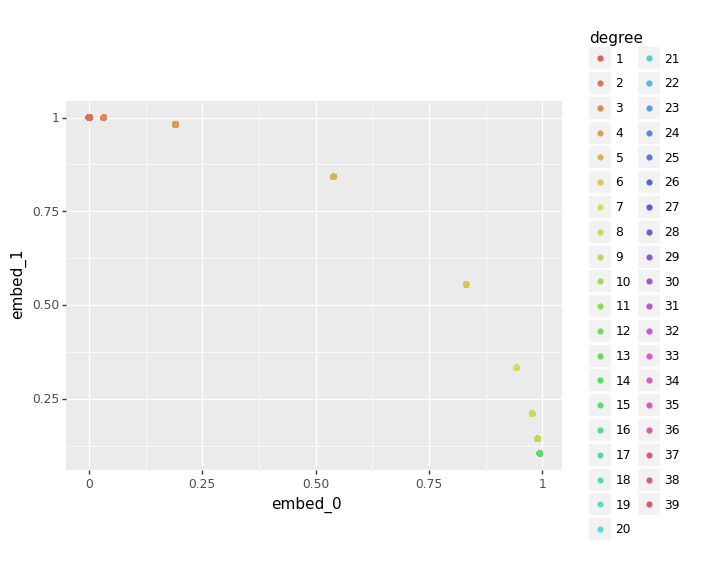

<ggplot: (17591905797514)>

In [225]:
fig = (
    pl.ggplot(data = embeds_degree, mapping = pl.aes(x = 'embed_0', y = 'embed_1', color = "degree", fill = "degree")) 
    + pl.geom_point()
    # + pl.labs(title = "Plot of embedding vector (2-dim) colored by outcome", 
    #           caption = "GraphSage, embedding dimension = 2, search depth = 1")
    # + pl.geom_boxplot(width=0.02)
    # + pl.geom_point(pl.aes(color = 'pred'), position = pl.position_jitterdodge(dodge_width = 0.5, jitter_height = 0.00000000000001))
)

fig

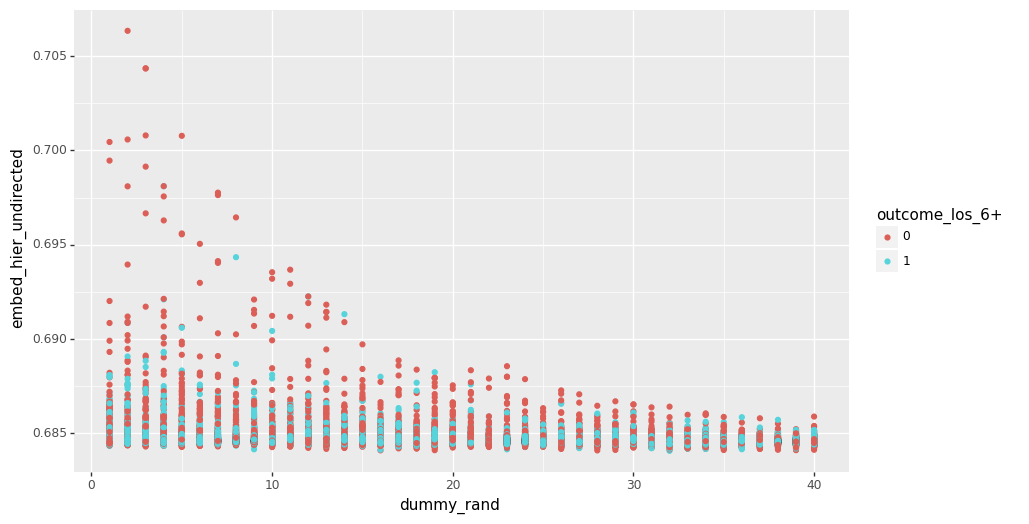

<ggplot: (17591878045603)>

In [431]:
# plotnine.options.figure_size = (6.4, 4.8)
pl.options.figure_size = (10, 6)
fig = (
    pl.ggplot(data = embeds_degree, mapping = pl.aes(x = 'dummy_rand', y = 'embed_hier_undirected', color = "outcome_los_6+", fill = "outcome_los_6+")) 
    + pl.geom_point()
    # + pl.labs(title = "Plot of embedding vector (2-dim) colored by outcome", 
    #           caption = "GraphSage, embedding dimension = 2, search depth = 1")
    # + pl.geom_boxplot(width=0.02)
    # + pl.geom_point(pl.aes(color = 'pred'), position = pl.position_jitterdodge(dodge_width = 0.5, jitter_height = 0.00000000000001))
)

fig

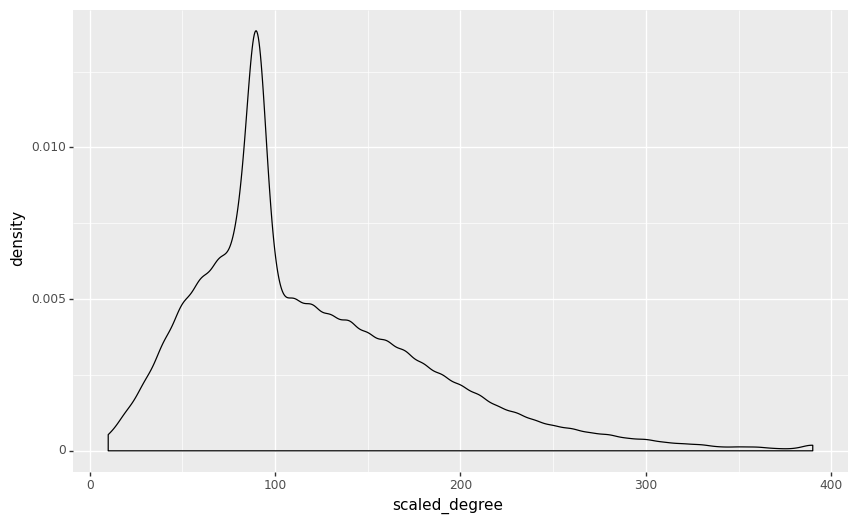

<ggplot: (17591908574833)>

In [395]:
pl.options.figure_size = (10, 6)
fig = (
    pl.ggplot(data = embeds_degree, mapping = pl.aes(x = 'scaled_degree')) 
    + pl.geom_density()
    # + pl.geom_ribbon(pl.aes(ymin=0, ymax=390))
    # + pl.labs(title = "Plot of embedding vector (2-dim) colored by outcome", 
    #           caption = "GraphSage, embedding dimension = 2, search depth = 1")
    # + pl.geom_boxplot(width=0.02)
    # + pl.geom_point(pl.aes(color = 'pred'), position = pl.position_jitterdodge(dodge_width = 0.5, jitter_height = 0.00000000000001))
)

fig

# ggplot(df.example, aes(x = value)) +
#   facet_grid(type ~ model) +
#   geom_density(aes(fill = model, colour = model)) +
#   geom_vline(data = d2, aes(xintercept = lower)) +
#   geom_vline(data = d2, aes(xintercept = upper))

In [274]:
name = projections["hier"]
print(f"***** {name} *****")
# to numpy matrixes
X = np.array([np.array(xi) for xi in embeds_outcome[f'embed_{name}']])
# print("X shape: ", np.shape(X))
y = np.array(embeds_outcome["outcome_los_6+"])
# print("y shape: ", np.shape(y))
hadm_id = np.array(embeds_outcome["hadm_id"])

# train/test
X_train, X_test, y_train, y_test, hadm_id_train, hadm_id_test = train_test_split(X, y,hadm_id, test_size=0.2,stratify=y, random_state=randomSeed)

lgbm_cls = lgb.LGBMClassifier(random_state = randomSeed)

lgbm_cls.fit(X_train, y_train)
y_pred = lgbm_cls.predict(X_test)
pred_proba = lgbm_cls.predict_proba(X_test)

# metrics:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
acc = round(accuracy_score(y_test, y_pred), 3)
prec = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
auc = round(roc_auc_score(y_test, pred_proba[:,1]), 3)
f1 = round(f1_score(y_test, y_pred), 3)

fpr, tpr, thresh = roc_curve(y_test, pred_proba[:,1])

print("TP: ", tp)
print("TN: ", tn)
print("FP: ", fp)
print("FN: ", fn)
print("Accuracy: ", acc)
print("F1: ", f1)
print("AUC: ", auc)

***** hier_natural *****
TP:  4395
TN:  2257
FP:  2146
FN:  1346
Accuracy:  0.656
F1:  0.716
AUC:  0.696


In [302]:
test_df = pd.DataFrame({"actual" : y_test, "predicted" : y_pred, "hadm_id" : hadm_id_test})
test_df = test_df.merge(embeds_degree[["hadm_id", "degree"]], on = "hadm_id")
test_df["actual"] = test_df["actual"].astype("category")
test_df["predicted"] = test_df["predicted"].astype("category")
test_df

,actual,predicted,hadm_id,degree
0,1,1,108862,14
1,0,0,113986,6
2,1,1,196405,20
3,0,0,188068,8
4,1,1,118227,16
...,...,...,...,...
10139,0,0,197265,8
10140,1,1,169004,9
10141,0,1,174338,11
10142,0,0,141126,2


In [303]:
# test_df_plot = pd.melt(test_df, id_vars=['hadm_id', 'degree'], value_vars=['actual', 'predicted'], value_name = "outcome")
# test_df_plot["outcome"] = test_df_plot["outcome"].astype("category")
# test_df_plot

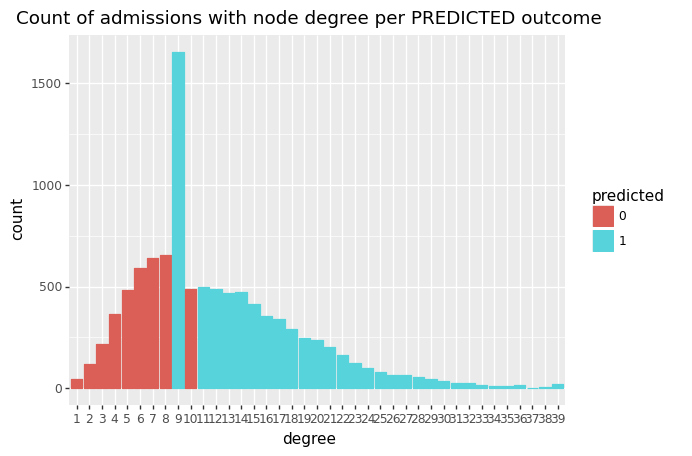

<ggplot: (17591872423255)>

In [312]:
fig = (
    pl.ggplot(data = test_df, mapping = pl.aes(x = 'degree', color = "predicted", fill = "predicted")) 
    + pl.geom_bar(position = pl.position_dodge(width = 1))
    + pl.labs(title = "Count of admissions with node degree per PREDICTED outcome")
    # + pl.geom_boxplot(width=0.02)
    # + pl.geom_point(pl.aes(color = 'pred'), position = pl.position_jitterdodge(dodge_width = 0.5, jitter_height = 0.00000000000001))
    # + pl.facet_wrap("variable")
)

fig

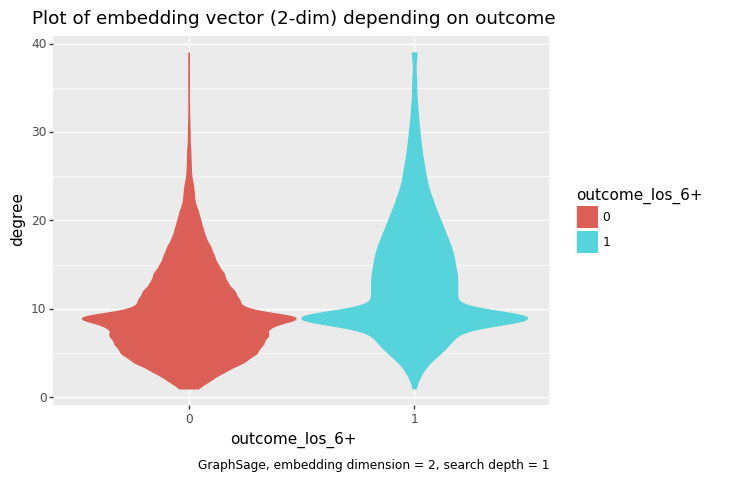

<ggplot: (17591883209065)>

In [145]:
fig = (
    pl.ggplot(data = embeds_degree, mapping = pl.aes(x = 'outcome_los_6+', y = 'degree', color = "outcome_los_6+", fill = "outcome_los_6+")) 
    + pl.geom_violin(trim=False, width=1, position=pl.position_dodge(width = 0.4))
    + pl.labs(title = "Plot of embedding vector (2-dim) depending on outcome", 
              caption = "GraphSage, embedding dimension = 2, search depth = 1")
    # + pl.geom_boxplot(width=0.02)
    # + pl.geom_point(pl.aes(color = 'pred'), position = pl.position_jitterdodge(dodge_width = 0.5, jitter_height = 0.00000000000001))
)

fig

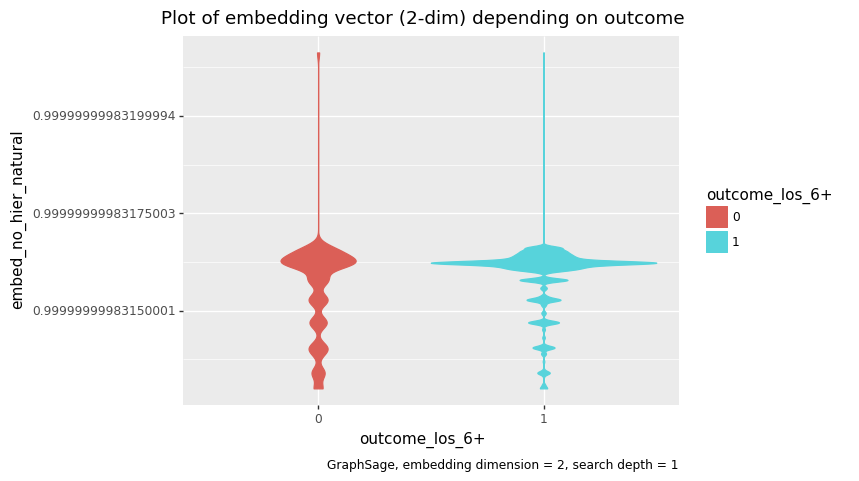

<ggplot: (17591883229929)>

In [146]:
fig = (
    pl.ggplot(data = embeds_degree, mapping = pl.aes(x = 'outcome_los_6+', y = 'embed_no_hier_natural', color = "outcome_los_6+", fill = "outcome_los_6+")) 
    + pl.geom_violin(trim=False, width=1, position=pl.position_dodge(width = 0.4))
    + pl.labs(title = "Plot of embedding vector (2-dim) depending on outcome", 
              caption = "GraphSage, embedding dimension = 2, search depth = 1")
    # + pl.geom_boxplot(width=0.02)
    # + pl.geom_point(pl.aes(color = 'pred'), position = pl.position_jitterdodge(dodge_width = 0.5, jitter_height = 0.00000000000001))
)

fig

## Predicting on embedding 1 dim

In [445]:
# merge with embeds
embeds_degree = embeds_outcome.merge(degree_hadm_map, left_on='hadm_id', right_on='hadm_id')
# embeds_degree["embed_no_hier_natural"] = embeds_degree.apply(lambda r: float(r['embed_no_hier_natural'][0]), axis = 1)
# embeds_degree["embed_hier_natural"] = embeds_degree.apply(lambda r: float(r['embed_hier_natural'][0]), axis = 1)
embeds_degree["outcome_los_6+"] = embeds_degree["outcome_los_6+"].astype("category")
embeds_degree = embeds_degree.sort_values(by=["hadm_id"])
embeds_degree.head(3)

# to numpy matrixes
X = np.array([np.array(xi) for xi in embeds_degree[f'embed_no_hier_undirected']])
# print("X shape: ", np.shape(X))
y = np.array(embeds_degree["outcome_los_6+"])
# print("y shape: ", np.shape(y))

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=randomSeed)

lgbm_cls = lgb.LGBMClassifier(random_state = randomSeed)

lgbm_cls.fit(X_train, y_train)
y_pred = lgbm_cls.predict(X_test)
pred_proba = lgbm_cls.predict_proba(X_test)

# metrics:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
acc = round(accuracy_score(y_test, y_pred), 3)
prec = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
auc = round(roc_auc_score(y_test, pred_proba[:,1]), 3)
f1 = round(f1_score(y_test, y_pred), 3)

fpr, tpr, thresh = roc_curve(y_test, pred_proba[:,1])

print("TP: ", tp)
print("TN: ", tn)
print("FP: ", fp)
print("FN: ", fn)
print("Accuracy: ", acc)
print("F1: ", f1)
print("AUC: ", auc)

TP:  4965
TN:  844
FP:  3559
FN:  776
Accuracy:  0.573
F1:  0.696
AUC:  0.548


## Predicting on node degree

In [446]:
# to numpy matrixes
X = np.array([[xi] for xi in embeds_degree[f'degree']])
# print("X shape: ", np.shape(X))
y = np.array(embeds_degree["outcome_los_6+"])
# print("y shape: ", np.shape(y))

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=randomSeed)

lgbm_cls = lgb.LGBMClassifier(random_state = randomSeed)

lgbm_cls.fit(X_train, y_train)
y_pred = lgbm_cls.predict(X_test)
pred_proba = lgbm_cls.predict_proba(X_test)

# metrics:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
acc = round(accuracy_score(y_test, y_pred), 3)
prec = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
auc = round(roc_auc_score(y_test, pred_proba[:,1]), 3)
f1 = round(f1_score(y_test, y_pred), 3)

fpr, tpr, thresh = roc_curve(y_test, pred_proba[:,1])

print("TP: ", tp)
print("TN: ", tn)
print("FP: ", fp)
print("FN: ", fn)
print("Accuracy: ", acc)
print("F1: ", f1)
print("AUC: ", auc)

TP:  4395
TN:  2257
FP:  2146
FN:  1346
Accuracy:  0.656
F1:  0.716
AUC:  0.696
